In [2]:
import os 
# list(os.walk('./data'))
for i in os.walk('./dataset'):
    if len(i[-1]) != 0:
        for fname in i[-1]:
            print(os.path.join(i[0], fname))

./dataset\test.csv
./dataset\train.csv


In [3]:
"""
    1. explore the data using pandas and numpy
    2. get the trend of the full data
    3. select the solutions
"""

import pandas as pd
import numpy as np
train_df = pd.read_csv('./dataset\\train.csv', header=0)
test_df = pd.read_csv('./dataset\\test.csv', header=0)

train_df.describe()

,dt,type,target
count,2.877305e+06,2.877305e+06,2.877305e+06
mean,2.576864e+02,3.232505e+00,3.221786e+01
std,1.429536e+02,2.832795e+00,5.035682e+01
min,1.100000e+01,0.000000e+00,-6.130000e-01
25%,1.340000e+02,1.000000e+00,1.331600e+01
50%,2.570000e+02,3.000000e+00,2.235000e+01
75%,3.810000e+02,5.000000e+00,3.443900e+01
max,5.060000e+02,1.800000e+01,1.191678e+03


In [4]:
import matplotlib.pyplot as plt
from functools import reduce

# groupby type and mean target

# version 1
# tmp_mean = train_df.groupby("type")["target"].mean().reset_index()
# tmp_max = train_df.groupby("type")["target"].max().reset_index()
# tmp_min = train_df.groupby("type")["target"].min().reset_index()
# tmp_df = reduce(
#     lambda left, right: pd.merge(left, right, on="type"), [tmp_mean, tmp_max, tmp_min]
# )
# tmp_df.__setattr__("columns", pd.Index(["type", "mean", "max", "min"]))

# version 2
tmp_df = (
    train_df.groupby("type")
    .agg(
        mean=pd.NamedAgg("target", "mean"),
        max=pd.NamedAgg("target", "max"),
        min=pd.NamedAgg("target", "min"),
    )
    .reset_index()
)
tmp_df.sort_values(by=["mean", "type"], ascending=[True, True], inplace=True)
tmp_df.reset_index(drop=True, inplace=True)

tmp_df

,type,mean,max,min
0,10,11.106217,211.708,-0.562
1,0,15.148306,73.537,-0.600
2,1,16.568822,116.194,-0.572
3,7,16.930145,272.600,-0.581
4,5,18.883830,68.083,-0.613
5,16,19.706511,40.380,3.104
6,11,26.653627,179.791,-0.256
7,2,31.732851,128.730,-0.513
8,3,36.778774,147.793,-0.425
9,4,37.760418,200.663,-0.527


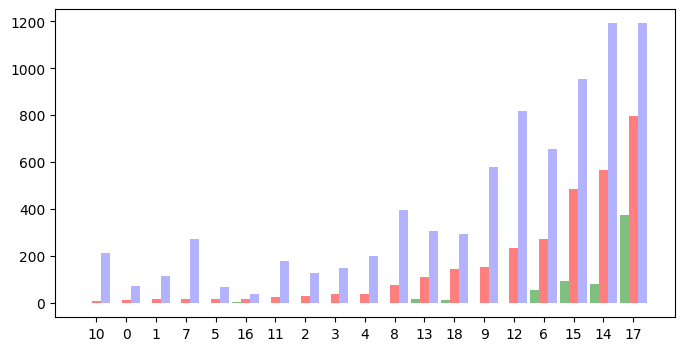

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

bar_width = 0.3
bar_positions = range(len(tmp_df))

# Plot mean
mean_bars = ax.bar(
    bar_positions,
    tmp_df["mean"],
    bar_width,
    tick_label=tmp_df.type,
    label="Mean",
    color="red",
    alpha=0.5,
)

# Plot max
max_bars = ax.bar(
    [pos + bar_width for pos in bar_positions],
    tmp_df["max"],
    bar_width,
    label="Max",
    color="blue",
    alpha=0.3,
)

# Plot min
min_bars = ax.bar(
    [pos - bar_width for pos in bar_positions],
    tmp_df["min"],
    bar_width,
    label="Min",
    color="green",
    alpha=0.5,
)

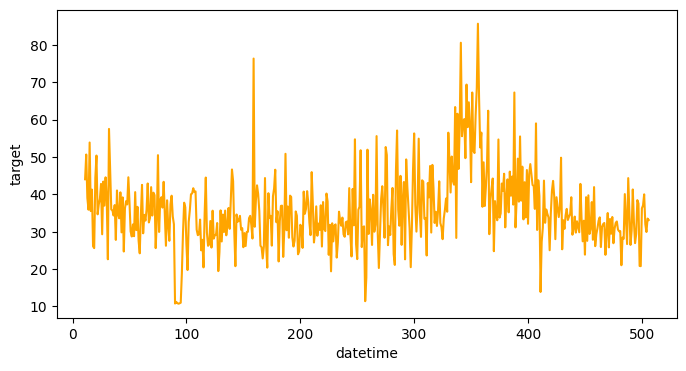

In [6]:
# explore the specific id
tmp_00037f39cf = train_df[train_df['id'] == '00037f39cf']
tmp_00037f39cf_sorted = tmp_00037f39cf.sort_values(by='dt', ascending=True)
tmp_00037f39cf_sorted = tmp_00037f39cf_sorted.reset_index(drop=True)
plt.figure(figsize=(8,4))
plt.plot(tmp_00037f39cf_sorted['dt'], tmp_00037f39cf_sorted['target'], color='orange')
plt.xlabel('datetime')
plt.ylabel('target')
plt.show()

[2, 4, 0, 5, 1, 3, 8, 13, 7, 10, 11, 12, 14, 9, 6, 15, 17, 16, 18]


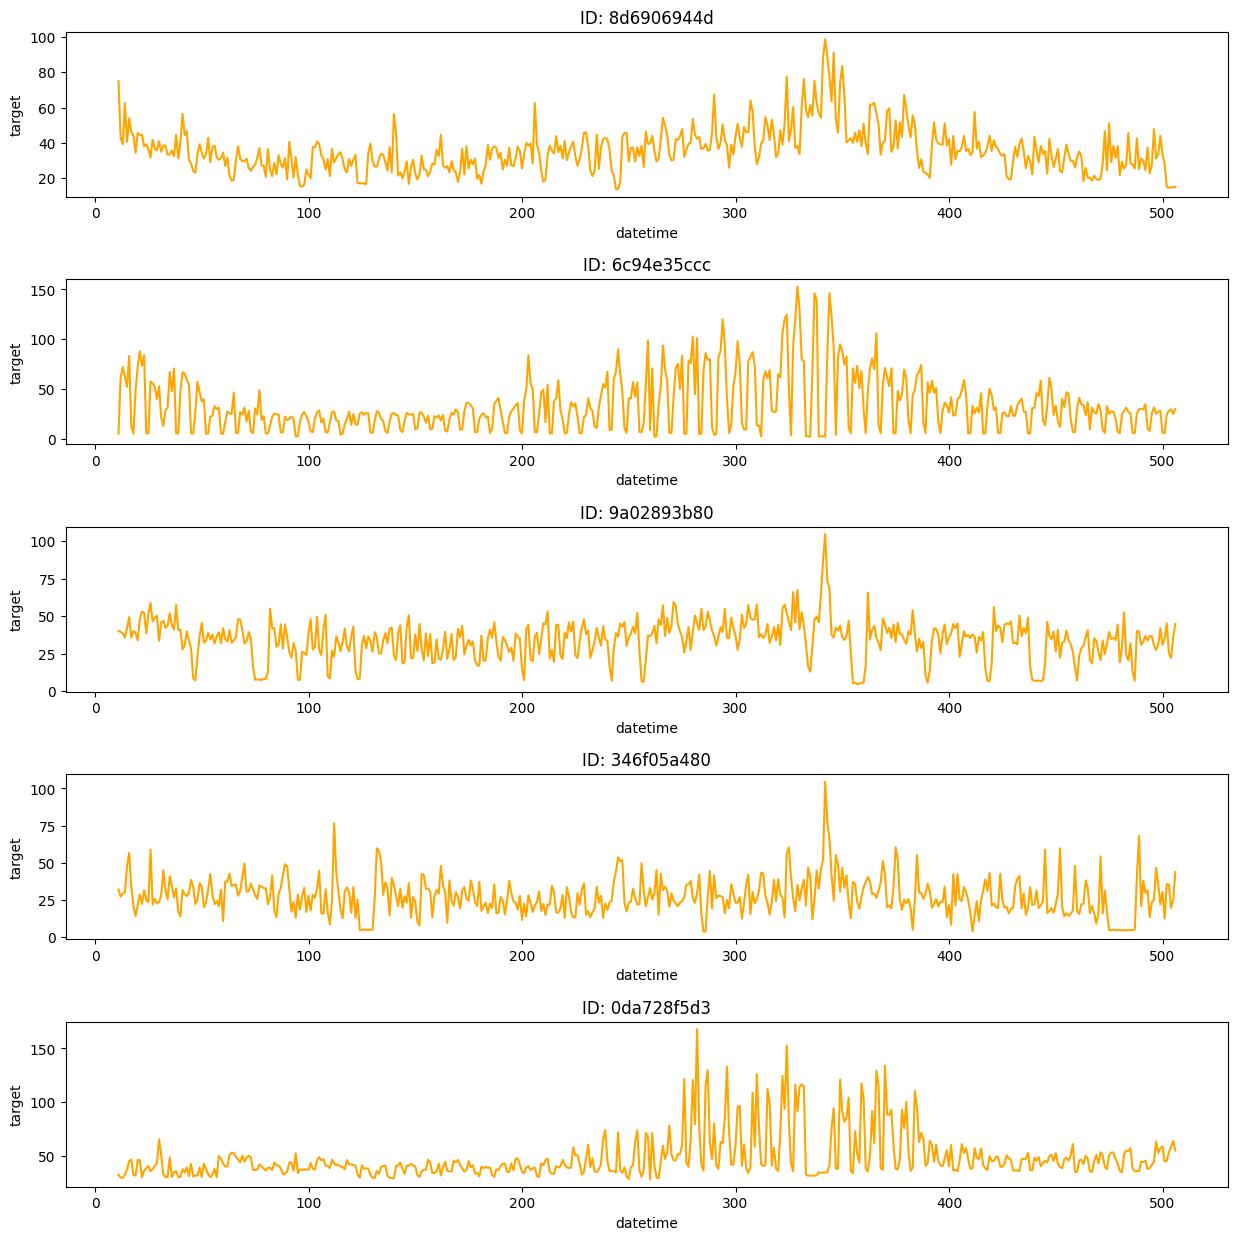

In [13]:
# show different type's trends
## get all types
unique_idtypes = (
    train_df.loc[:, ["id", "type"]]
    .drop_duplicates(subset=["id"])
    .reset_index(drop=True)
)
types = unique_idtypes["type"].drop_duplicates().tolist()
print(types)


def plot_type_trend(type, df, snum):

    # create the subplots of
    _, axes = plt.subplots(nrows=snum, ncols=1, figsize=(15, 15))
    figs = axes.flatten()

    ids = unique_idtypes[unique_idtypes["type"] == type]

    random_ids = ids.sample(snum)["id"].values
    for i, id in enumerate(random_ids):

        tmp = df[df["id"] == id].sort_values(by="dt").reset_index(drop=True)

        figs[i].plot(tmp["dt"], tmp["target"], color="orange")

        figs[i].set_xlabel("datetime")

        figs[i].set_ylabel("target")

        figs[i].set_title(f"ID: {id}")

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    plt.show()

plot_type_trend(4, train_df, 5)

In [ ]:
# 合并训练数据和测试数据，并进行排序
data = pd.concat([test_df, train_df], axis=0, ignore_index=True)
data = data.sort_values(['id','dt'], ascending=False).reset_index(drop=True)

# 历史平移
for i in range(10,30):
    data[f'last{i}_target'] = data.groupby(['id'])['target'].shift(i)
data
    
# 窗口统计
data[f'win3_mean_target'] = (data['last10_target'] + data['last11_target'] + data['last12_target']) / 3

# 进行数据切分
train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isnull()].reset_index(drop=True)

# # 确定输入特征
train_cols = [f for f in data.columns if f not in ['id','target']]
# train_cols